<a href="https://colab.research.google.com/github/AhmdKlmi22/Training_Model/blob/main/Tugas2_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install tensorflow opencv-python matplotlib split-folders

In [6]:
pip install split-folders

In [7]:
import splitfolders  # Library khusus untuk split dataset
import zipfile

# 🛠️ SESUAIKAN PATH DAN UKURAN GAMBAR
dataset_path = "/content/drive/MyDrive/Data_Tugas/dompet.zip"  # Ganti dengan path mu
img_size = (150, 150)  # Bisa ubah ke (224,224) untuk model lebih kompleks

# Ekstrak dataset
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall("/drive/MyDrive/Data_Tugas/dataset_raw")

# Split dataset jadi train/val/test (80/10/10)
splitfolders.ratio(
    "/drive/MyDrive/Data_Tugas/dataset_raw",
    output="/drive/MyDrive/Data_Tugas/dataset_split",
    seed=42,
    ratio=(0.8, 0.1, 0.1)
)

print("Dataset sudah di-split!")

Copying files: 1245 files [00:00, 2619.81 files/s]

Dataset sudah di-split!


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 🛠️ PARAMETER AUGMENTASI (sesuaikan kebutuhan)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
    fill_mode='constant'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)  # Tidak augmentasi untuk validasi & test

# 🛠️ BATCH SIZE (default 32)
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    "/drive/MyDrive/Data_Tugas/dataset_split/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    "/drive/MyDrive/Data_Tugas/dataset_split/val",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Penting untuk evaluasi
)

test_generator = val_test_datagen.flow_from_directory(
    "/drive/MyDrive/Data_Tugas/dataset_split/test",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 994 images belonging to 4 classes.
Found 124 images belonging to 4 classes.
Found 127 images belonging to 4 classes.


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')  # 4 kelas
])

# 🛠️ PILIH OPTIMIZER (default: Adam)
model.compile(
    optimizer='tf.keras.optimizers.Adam(learning_rate=0.00001)',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,636,868 (40.58 MB)

 Trainable params: 10,636,868 (40.58 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# 🛠️ SESUAIKAN EPOCH & STEPS (default: 20 epoch)
epochs = 20
steps_per_epoch = train_generator.samples // batch_size
validation_steps = val_generator.samples // batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.4217 - loss: 1.6017 - val_accuracy: 0.5417 - val_loss: 1.2451
Epoch 2/20
 1/31 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.5625 - loss: 1.0621

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5625 - loss: 1.0621 - val_accuracy: 0.5417 - val_loss: 1.2675
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.6694 - loss: 0.7986 - val_accuracy: 0.8333 - val_loss: 0.4805
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7188 - loss: 0.6158 - val_accuracy: 0.8438 - val_loss: 0.4631
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.7614 - loss: 0.5768 - val_accuracy: 0.8438 - val_loss: 0.3797
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.8438 - loss: 0.3905 - val_accuracy: 0.8438 - val_loss: 0.3787
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8101 - loss: 0.4627 - val_accuracy: 0.8438 - val_loss: 0.3661
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7812 - loss: 0.4725 - val_accuracy: 0.8750 - val_loss: 0.3716
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8805 - loss: 0.3465 - val_accuracy: 0.8750 - val_loss: 0.312

In [12]:
# Evaluasi dengan data test
test_loss, test_acc = model.evaluate(test_generator)
print(f"Accuracy di data test: {test_acc*100:.2f}%")

# Simpan model
model.save('/drive/MyDrive/Data_Tugas/model_4kelas.h5')

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step - accuracy: 0.9384 - loss: 0.2113


Accuracy di data test: 94.49%


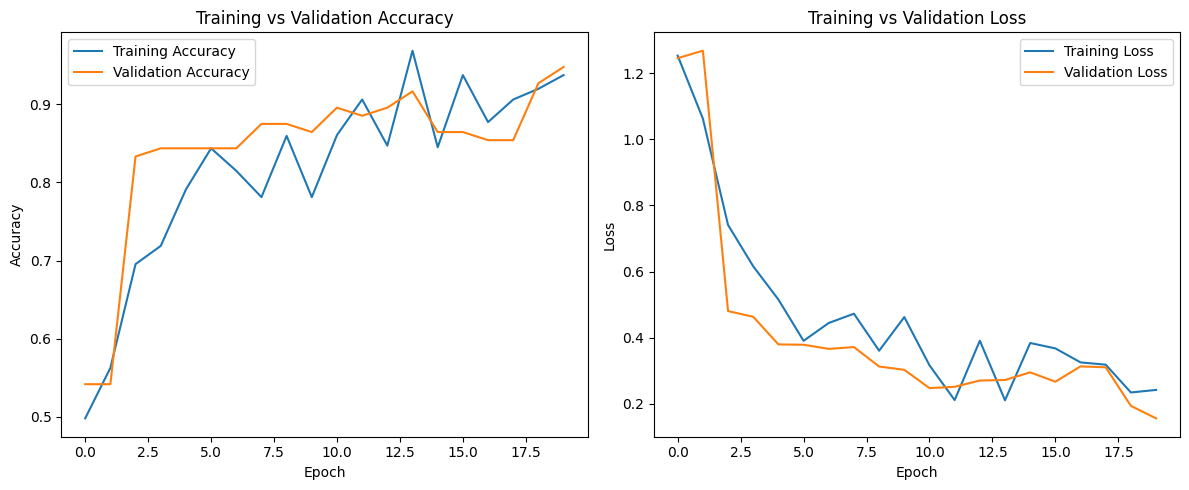

In [13]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 341ms/step


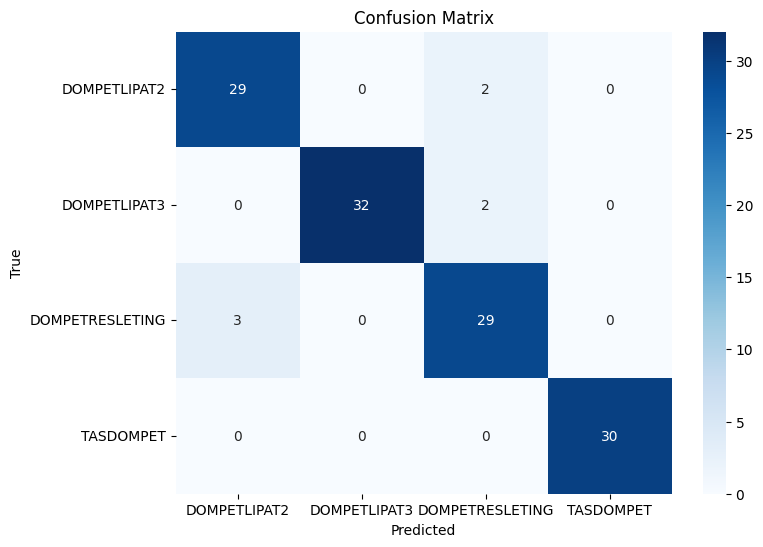

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Prediksi data test
test_pred = model.predict(test_generator)
test_pred_classes = np.argmax(test_pred, axis=1)
true_classes = test_generator.classes

# Buat Confusion Matrix
cm = confusion_matrix(true_classes, test_pred_classes)
class_names = list(test_generator.class_indices.keys())

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [15]:
from sklearn.metrics import classification_report

print(classification_report(
    true_classes,
    test_pred_classes,
    target_names=class_names
))

                 precision    recall  f1-score   support

   DOMPETLIPAT2       0.91      0.94      0.92        31
   DOMPETLIPAT3       1.00      0.94      0.97        34
DOMPETRESLETING       0.88      0.91      0.89        32
      TASDOMPET       1.00      1.00      1.00        30

       accuracy                           0.94       127
      macro avg       0.95      0.95      0.95       127
   weighted avg       0.95      0.94      0.95       127

